In [1]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from unet import unet_model
import random
from pathlib import Path
import logging
import itertools

LOGGER = logging.getLogger()
from datetime import datetime

from skimage.morphology import binary_erosion
from skimage.morphology import skeletonize
from skimage.filters import hessian
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.color import label2rgb

import tensorflow as tf
from sklearn.model_selection import train_test_split

for key, value in os.environ.items():
    print(f"{key} : {value}")

2023-10-18 21:25:54.408650: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CHROME_DESKTOP : code-url-handler.desktop
DBUS_SESSION_BUS_ADDRESS : unix:path=/run/user/1000/bus
DEFAULTS_PATH : /usr/share/gconf/pop.default.path
DESKTOP_SESSION : pop
DISPLAY : :1
ELECTRON_NO_ATTACH_CONSOLE : 1
GDK_BACKEND : x11
GDMSESSION : pop
GIO_LAUNCHED_DESKTOP_FILE : /usr/share/applications/gitkraken.desktop
GIO_LAUNCHED_DESKTOP_FILE_PID : 3708
GJS_DEBUG_OUTPUT : stderr
GJS_DEBUG_TOPICS : JS ERROR;JS LOG
GNOME_DESKTOP_SESSION_ID : this-is-deprecated
GNOME_SHELL_SESSION_MODE : pop
GPG_AGENT_INFO : /run/user/1000/gnupg/S.gpg-agent:0:1
GTK_IM_MODULE : ibus
GTK_MODULES : gail:atk-bridge
HOME : /home/sylvia
INVOCATION_ID : 4efe8b6744ab463087e1902acf6c2bee
JOURNAL_STREAM : 8:34515
LANG : en_US.UTF-8
LOGNAME : sylvia
MANAGERPID : 2590
MANDATORY_PATH : /usr/share/gconf/pop.mandatory.path
ORIGINAL_XDG_CURRENT_DESKTOP : Unity
PATH : /home/sylvia/anaconda3/envs/car-or-truck-p9/bin:/home/sylvia/anaconda3/condabin:/home/sylvia/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/s

2023-10-18 21:25:55.921569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-18 21:25:55.925286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-18 21:25:55.925442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-18 21:25:55.925765: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [2]:
# Ensure that your GPU is working
tf.test.gpu_device_name()

2023-10-18 21:25:56.745297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


'/device:GPU:0'

2023-10-18 21:25:56.745513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-18 21:25:56.745662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-18 21:25:56.745875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-18 21:25:56.746033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-18 21:25:56.746151: I tensorflow/core/common_runtime/gpu/gpu

In [3]:
# Set the random seeds
SEED = 0
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# MacOS
ORIGINAL_IMAGE_DIR = Path("/Users/sylvi/topo_data/hariborings/training_data/on_target_flattened")
MASK_DIR = Path("/Users/sylvi/topo_data/hariborings/training_data/on_target_labelled")

# Linux
ORIGINAL_IMAGE_DIR = Path("/home/sylvia/haribo_data/training_data/on_target_flattened")
MASK_DIR = Path("/home/sylvia/haribo_data/training_data/on_target_labelled")

MODEL_SAVE_DIR = Path("./saved_models")
CHANNELS = 1

BATCH_SIZE = 5

# Get the number of .png images
NUM_IMAGES = len(list(ORIGINAL_IMAGE_DIR.glob("*.png")))
print(f"Number of images: {NUM_IMAGES}")

Number of images: 9


In [5]:
# An image generator that loads images as they are needed
def image_generator(image_indexes, batch_size=4):
    while True:
        # Select files (paths/indices) for the batch
        batch_image_indexes = np.random.choice(a=image_indexes, size=batch_size)
        batch_input = []
        batch_output = []

        # Load the image and ground truth
        for index in batch_image_indexes:
            # Find the index as the only number in the filename
            # index = re.search(r"\d+", image_path)
            # print(index)
            image = cv2.imread(str(ORIGINAL_IMAGE_DIR / f"image_{index}.png"), 0)
            image = Image.fromarray(image)
            image = image.resize((512, 512))
            image = np.array(image)
            # Normalise the image
            image = image - np.min(image)
            image = image / np.max(image)

            # ground_truth = np.load(MASK_DIR / f"mask_array_{index}.npy")
            ground_truth = cv2.imread(str(MASK_DIR / f"mask_{index}.png"), 0)
            ground_truth = Image.fromarray(ground_truth)
            ground_truth = np.array(ground_truth)
            ground_truth = ground_truth.astype(bool)
            ground_truth = Image.fromarray(ground_truth.astype(np.uint8))
            ground_truth = ground_truth.resize((512, 512))
            ground_truth = np.array(ground_truth).astype(int)

            # Augment the images
            # Flip the images 50% of the time
            if random.choice([0, 1]) == 1:
                image = np.flip(image, axis=1)
                ground_truth = np.flip(ground_truth, axis=1)
            # Rotate the images by either 0, 90, 180, or 270 degrees
            rotation = random.choice([0, 1, 2, 3])
            image = np.rot90(image, rotation)
            ground_truth = np.rot90(ground_truth, rotation)

            batch_input.append(image)
            batch_output.append(ground_truth)

        batch_x = np.array(batch_input).astype(np.float32)
        batch_y = np.array(batch_output).astype(np.float32)

        yield (batch_x, batch_y)

image shape: (512, 512)
image max: 1.0
image min: 0.0


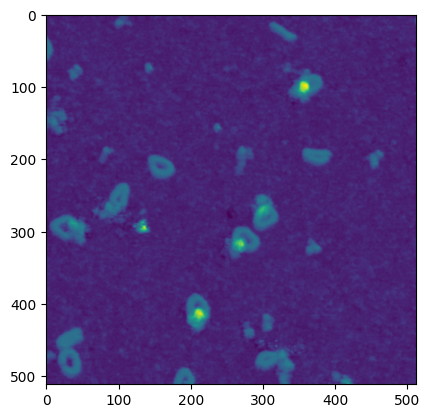

mask shape: (512, 512)
mask unique: [0. 1.]


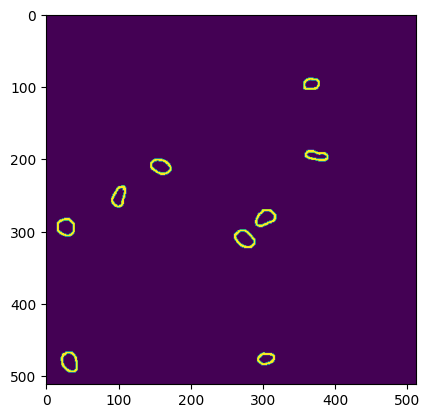

mask dtype: float32
image shape: (512, 512)
image max: 1.0
image min: 0.0


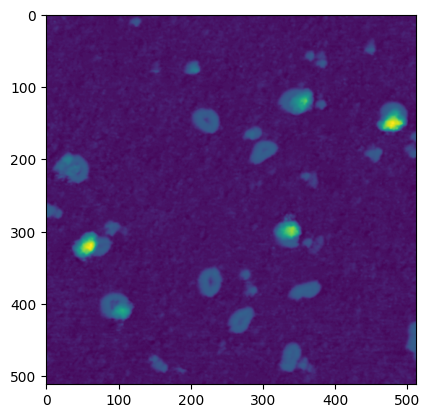

mask shape: (512, 512)
mask unique: [0. 1.]


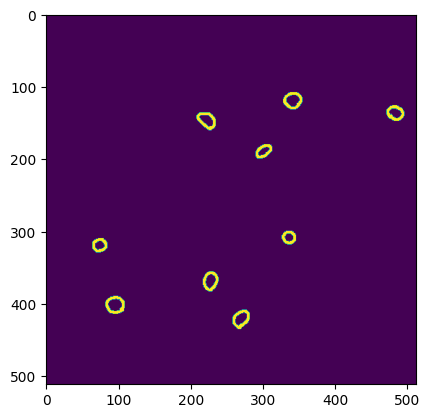

mask dtype: float32
image shape: (512, 512)
image max: 1.0
image min: 0.0


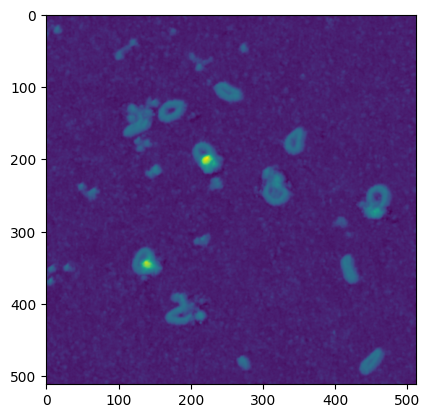

mask shape: (512, 512)
mask unique: [0. 1.]


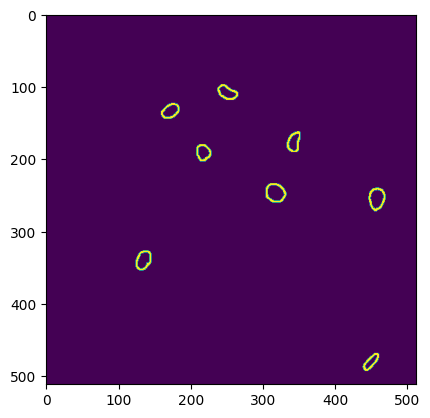

mask dtype: float32
image shape: (512, 512)
image max: 1.0
image min: 0.0


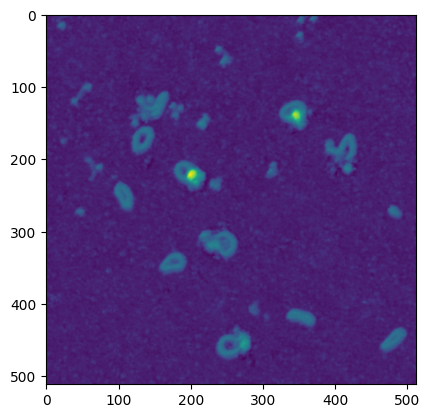

mask shape: (512, 512)
mask unique: [0. 1.]


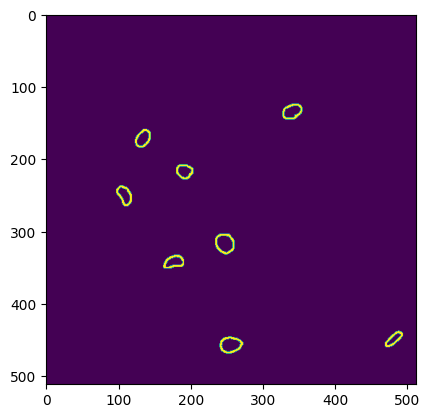

mask dtype: float32


In [6]:
# Check that the generator is doing the right thing
batch_generator = image_generator([0, 1, 2, 3, 4], batch_size=4)
(batch_x, batch_y) = next(batch_generator)
for image, mask in zip(batch_x, batch_y):
    plt.imshow(image)
    print(f"image shape: {image.shape}")
    print(f"image max: {np.max(image)}")
    print(f"image min: {np.min(image)}")
    plt.show()
    plt.imshow(mask)
    print(f"mask shape: {mask.shape}")
    print(f"mask unique: {np.unique(mask)}")
    plt.show()

    print(f"mask dtype: {mask.dtype}")

In [7]:
# Split what images are used for training and validation
train_image_indexes, validation_image_indexes = train_test_split(range(0, NUM_IMAGES), test_size=0.2, random_state=SEED)

print(f"Number of training images: {len(train_image_indexes)}")
print(f"Number of validation images: {len(validation_image_indexes)}")

print(f"Training image indexes: {train_image_indexes}")
print(f"Validation image indexes: {validation_image_indexes}")

# Create the generators
train_generator = image_generator(train_image_indexes, batch_size=4)
validation_generator = image_generator(validation_image_indexes, batch_size=4)

Number of training images: 7
Number of validation images: 2
Training image indexes: [1, 4, 8, 6, 3, 0, 5]
Validation image indexes: [7, 2]


In [8]:
# Get the model
model = unet_model(IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=CHANNELS)
# model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [9]:
EPOCHS = 200
history = model.fit(
    train_generator,
    # How many steps (batches of samples) to draw from generator before declaring one epoch finished and starting the next epoch
    steps_per_epoch=NUM_IMAGES // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    # How many steps (batches) to yield from validation generator at the end of every epoch
    validation_steps=NUM_IMAGES // BATCH_SIZE,
    verbose=1,
)

Epoch 1/200


2023-10-18 21:25:59.065709: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-18 21:25:59.225843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800
2023-10-18 21:25:59.819323: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 3s 3s/step - loss: 0.9314 - mean_io_u: 0.4968 - val_loss: 0.8848 - val_mean_io_u: 0.4967
Epoch 2/200
1/1 [==============================] - 0s 263ms/step - loss: 0.8171 - mean_io_u: 0.4945 - val_loss: 0.8393 - val_mean_io_u: 0.4961
Epoch 3/200
1/1 [==============================] - 0s 228ms/step - loss: 0.7909 - mean_io_u: 0.4944 - val_loss: 0.8016 - val_mean_io_u: 0.4955
Epoch 4/200
1/1 [==============================] - 0s 285ms/step - loss: 0.7949 - mean_io_u: 0.4949 - val_loss: 0.7857 - val_mean_io_u: 0.4961
Epoch 5/200
1/1 [==============================] - 0s 344ms/step - loss: 0.7633 - mean_io_u: 0.4945 - val_loss: 0.7727 - val_mean_io_u: 0.4967
Epoch 6/200
1/1 [==============================] - 0s 218ms/step - loss: 0.7568 - mean_io_u: 0.4961 - val_loss: 0.7438 - val_mean_io_u: 0.4961
Epoch 7/200
1/1 [==============================] - 0s 286ms/step - loss: 0.7342 - mean_io_u: 0.4957 - val_loss: 0.7338 - val_mean_io_u: 0.4967
Epoch 8/200
1/

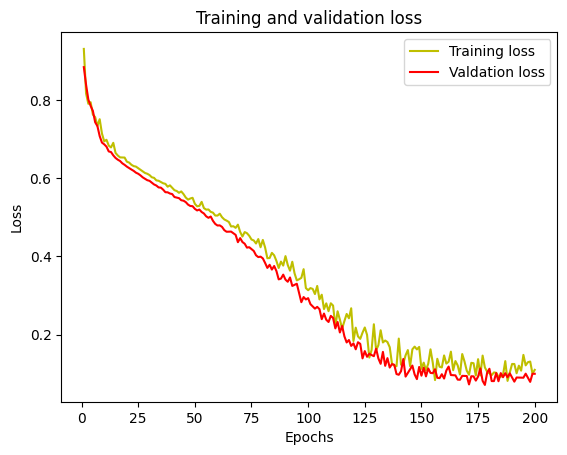

dict_keys(['loss', 'mean_io_u', 'val_loss', 'val_mean_io_u'])


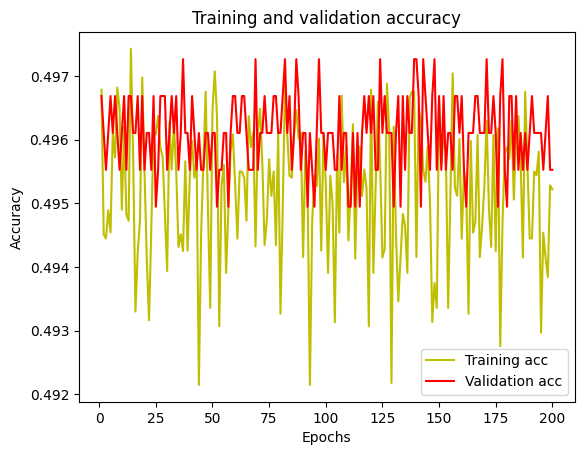

In [12]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Valdation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


print(history.history.keys())
acc = history.history["mean_io_u"]
val_acc = history.history["val_mean_io_u"]

# acc = history.history["accuracy"]
# val_acc = history.history["val_accuracy"]

plt.plot(epochs, acc, "y", label="Training acc")
plt.plot(epochs, val_acc, "r", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

1/1 [==============================] - 0s 18ms/step


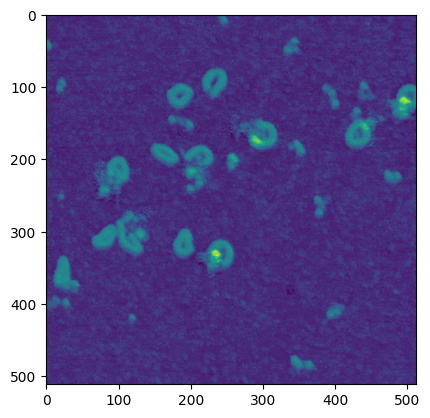

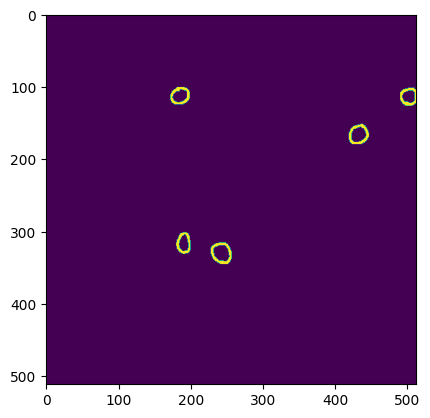

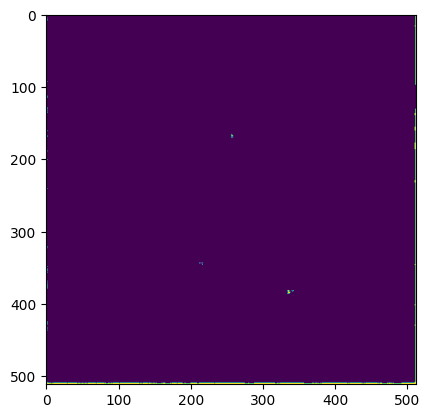

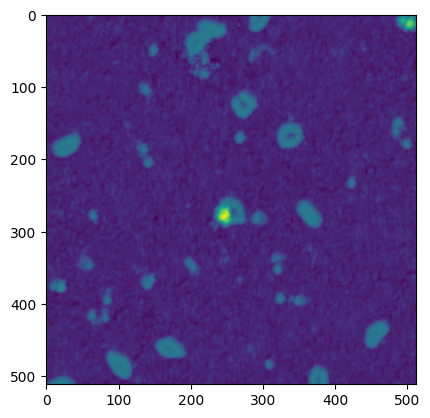

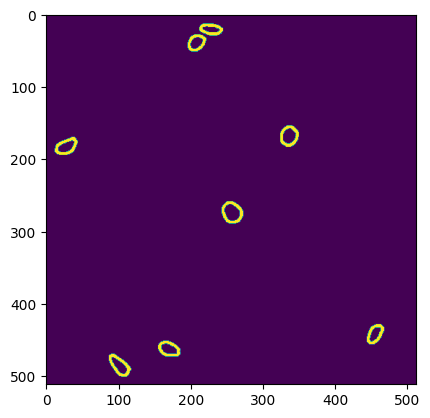

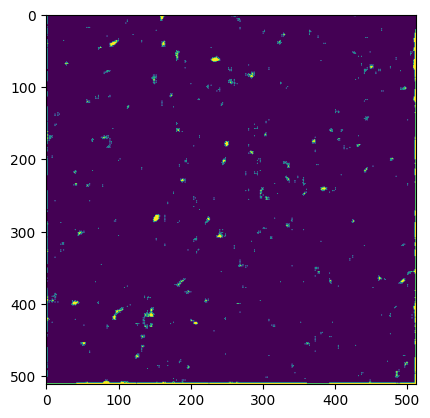

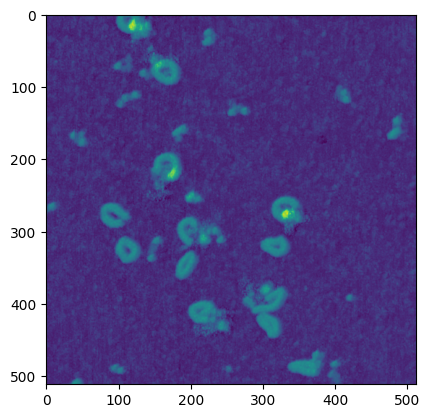

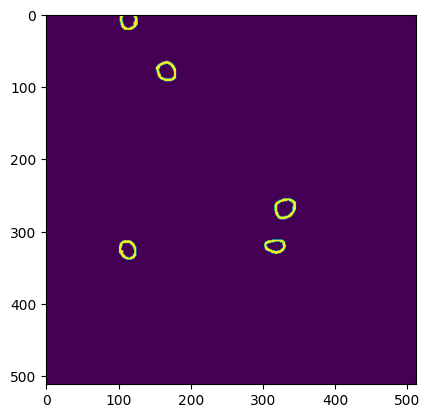

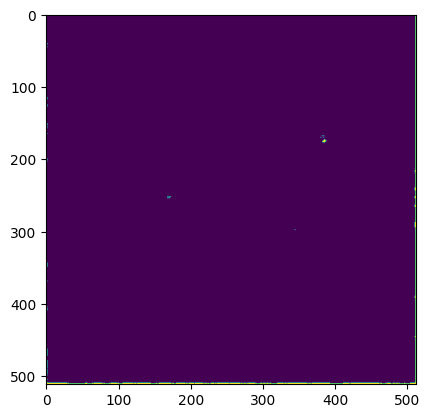

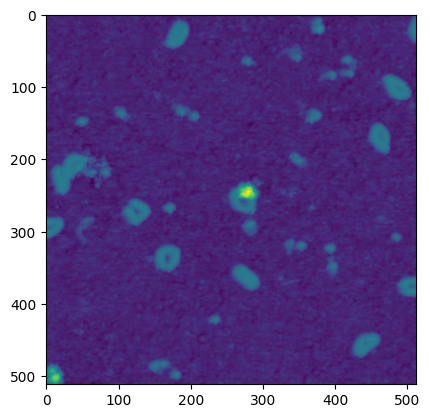

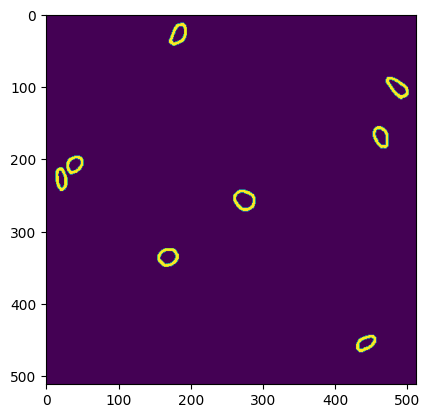

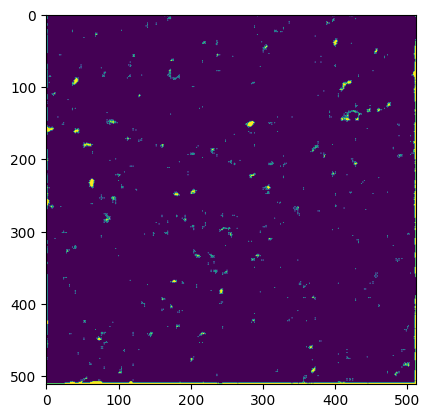

In [16]:
# Show the results of the model on the testing set using the validation generator
# Get the next batch from the generator
(batch_x, batch_y) = next(validation_generator)
# Predict the masks
predicted_masks = model.predict(batch_x)
# Threshold the masks
predicted_masks = (predicted_masks > 0.05).astype(np.uint8)
# Show the results
for image, mask, predicted_mask in zip(batch_x, batch_y, predicted_masks):
    plt.imshow(image)
    plt.show()
    plt.imshow(mask)
    plt.show()
    plt.imshow(predicted_mask)
    plt.show()